In [1]:
from sklearn.datasets import fetch_openml # MNIST 다운받기
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
x,y = mnist["data"],mnist["target"] # data와 lable 가져오기

In [3]:
import numpy as np
x.shape,y.shape
y = y.astype(np.uint8)

(-0.5, 27.5, 27.5, -0.5)

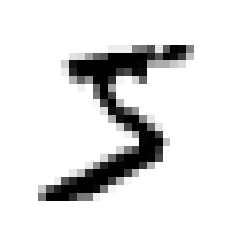

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 배열로 된 입력된 값 이미지로 구현하기

some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')

In [5]:
y[0]

5

In [6]:
# train data와 test data 나누기
x_train,x_test,y_train,y_test = x[:60000],x[60000:],y[:60000],y[60000:]

# 이진 분류 훈련(5판별기)

In [7]:
# 벡터 타깃 만들기
y_train_5 = (y_train==5) # numpy.ndarray를 bool로 바꿔준다.
y_test_5 = (y_test==5)


In [8]:
# 확률적 경사하강법 사용
# 사이킷런 SGDClassifier

from sklearn.linear_model import SGDClassifier

sdg_clf = SGDClassifier(random_state=42)
sdg_clf.fit(x_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sdg_clf.predict([some_digit])

array([ True])

## 성능측정

In [10]:
# 교차검증 2장에서 사용한 cross_val_score() 와 유사한 방법을 직접 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds =  StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train,y_train_5):
    
    clone_clf = clone(sdg_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_cross = sum(y_pred == y_test_fold)
    print(n_cross/len(y_pred))

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sdg_clf,x_train,y_train_5,cv=10,scoring='accuracy')

array([0.96416667, 0.95866667, 0.96416667, 0.95833333, 0.96733333,
       0.96933333, 0.96433333, 0.96583333, 0.9575    , 0.96566667])

In [12]:
# 그냥 5가 아니라고 하는 함수 만들기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
     
    def fit(self,x,y=None):
        return self
    
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)

In [13]:
never_5_classifier = Never5Classifier()
cross_val_score(never_5_classifier,x_train,y_train_5,cv=5,scoring='accuracy')

#결과가 정확도 90을 넘는다 특정 레이블이 다른 것보다 월등히 많을 경우 적합하지 않은 검증법이다.

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

## 오차 행렬

In [14]:
'''
1. 실제 값과 비교할 수 있는 예측값을 만든다.cross_val_preict() 를 이용한다.
2. 오차 행렬을 만든다. confusion_matricx() 를 이용한다.
'''

'\n1. 실제 값과 비교할 수 있는 예측값을 만든다.cross_val_preict() 를 이용한다.\n2. 오차 행렬을 만든다. confusion_matricx() 를 이용한다.\n'

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sdg_clf,x_train,y_train_5,cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
# 정밀도, 재현율 함수

from sklearn.metrics import precision_score, recall_score

a = precision_score(y_train_5,y_train_pred) # 정밀도
b = recall_score(y_train_5,y_train_pred) # 재현율
print(a,b)

0.8370879772350012 0.6511713705958311


In [18]:
# F1 점수 (정밀도와 재현율의 조화 평균)

from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [19]:
# 임곗값을 입력하여 정밀도, 재현율 조정하기
# predict() 함수 대신 decision_function() 사용하여 점수를 얻는다.

y_score = sdg_clf.decision_function([some_digit])
print(y_score)

tresholds = 0 # 임곗값
y_some_digit_pred = (y_score > tresholds)
print(y_some_digit_pred)

tresholds = 8000 # 임곗값
y_some_digit_pred = (y_score > tresholds)
print(y_some_digit_pred)

#임곗값 설정에 따라 결과가 다르게 반환된다.

[2164.22030239]
[ True]
[False]


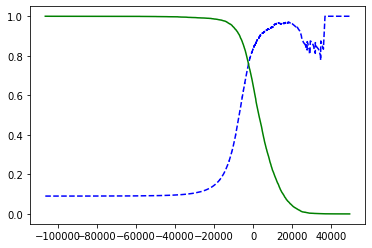

In [20]:
# 정밀도, 재현율 그래프 그리기

y_scores = cross_val_predict(sdg_clf,x_train,y_train_5,cv=3,method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1],'b--',label='정밀도')
    plt.plot(thresholds, recalls[:-1],'g-',label='재현율')
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

In [21]:
precisions[-1],recalls[-1]

(1.0, 0.0)

In [22]:
# 목표치에 따른 임계값 찾기
threshold_90_precison = thresholds[np.argmax(precisions>= 0.95)]
threshold_90_precison

10480.508645329957

In [23]:
y_train_pred_90 = (y_scores >= threshold_90_precison) # y_score = 각 test별 점수(임곗값)를 담고 있다 원하는 임곗값 이상만 True인 리스트 만들기

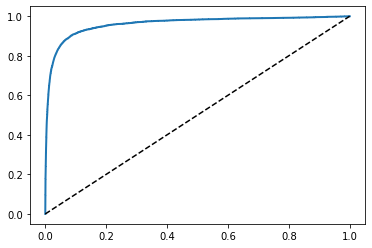

In [24]:
# ROC 곡선 그리기
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)

In [25]:
# 곡선아래 면적 AUC 를 이용한 분류기 비교

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

## RandomForestClassifier 사용하기

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv=3,method='predict_proba') 

#RandomForestClassifier에는 decision_function()이 없어서 predict_proba를 사용한다. (점수가 아닌 퍼센트로 반환) 

In [27]:
y_scores_forest = y_probas_forest[:,1] # 확률값

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Playdata\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53

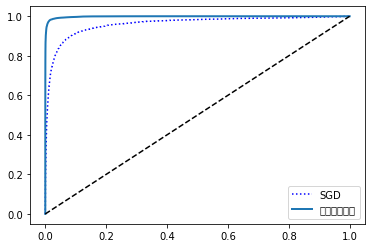

In [28]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'랜덤포레스트')
plt.legend(loc='lower right')

In [29]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [30]:
y_train_pred_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv=3)

In [31]:
a = precision_score(y_train_5,y_train_pred_forest) # 정밀도
b = recall_score(y_train_5,y_train_pred_forest) # 재현율
print(a,b)

0.9905083315756169 0.8662608374838591


# 다중분류

In [33]:
# 서포트 벡터 머신을 이용

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
np.argmax(some_digit_scores) # 가장 높은 점수

5

In [41]:
svm_clf.classes_ # lable을 모아놓은 list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
# OvO, OvR 강제하기

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [45]:
# sdg를 이용한 다중분류 # sdg 는 따로 OvO, OvR을 지정할 필요가 없다.

sdg_clf.fit(x_train,y_train)
sdg_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
sdg_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
# 성능 검증
cross_val_score(sdg_clf,x_train,y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [51]:
# 스케일링을 통한 정확도 높이기

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sdg_clf,x_train_scaled,y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# 에러분석

In [53]:
# 오차행렬 만들기

y_train_pred = cross_val_predict(sdg_clf,x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

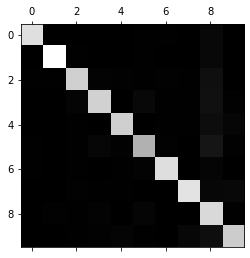

In [54]:
# 이미지로 확인하기
# 대각선이 올바르게 분류된 항목, 색이 어둡다면 데이터가 부족하거나 분류기의 성능이 떨어진다는 것을 의미한다.
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

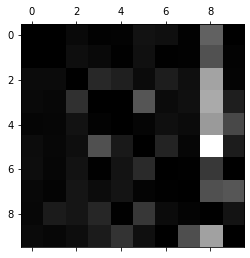

In [55]:
# ERROR에 초점 맞춰 확인하기

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums # lable 별 에러비율
np.fill_diagonal(norm_conf_mx,0) # 대각선 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [58]:
# 이미지화 함수

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

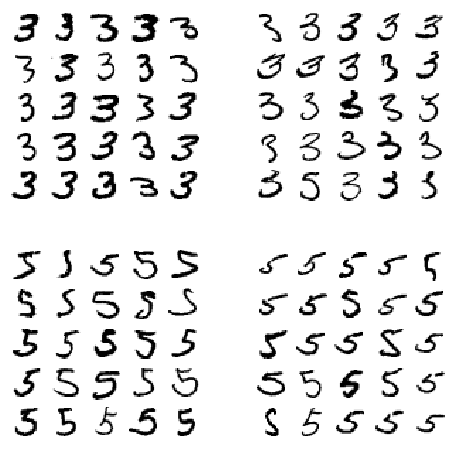

In [59]:
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
plt.show()

# 다중 레이블 분류

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7보다 크거나 같다, lable
y_train_odd = (y_train % 2 == 1) # 홀수 lable
y_multilable = np.c_[y_train_large,y_train_odd] # 2개의 lable을 갖는 y

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilable)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [64]:
# 다중레이블 분류기 평가(F1값 이용하기)

y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilable, cv=5)
f1_score(y_multilable,y_train_knn_pred,average='macro')

KeyboardInterrupt: 

# 다중 출력 다중 레이블 분류

In [65]:
noise = np.random.randint(0,100,(len(x_train),784))
x_train_mod = x_train + noise # 리스트 합이 아닌 np.array합
noise = np.random.randint(0,100,(len(x_test),784))
x_test_mod = x_test + noise

y_train_mod = x_train
y_test_mod = x_test

In [69]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

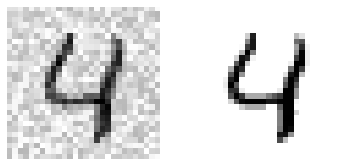

In [72]:
some_index = 4
plt.subplot(121); plot_digit(x_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

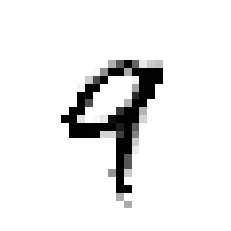

In [73]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_train_mod[some_index]])
plot_digit(clean_digit)